<h1 align='center'>Neural Networks and Deep Learning</h1>
<img align='right' src='https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova.png' alt='Drawing' width='300'>


<h2 align='left'>Homework 1 - Supervised Deep Learning</h2>


<h3 align='left'>University of Padua - Physics of Data</h3>
<h4 align='left'>Dott. Alberto Testolin, Dott. Umberto Micheli</h4>

**Name** | **ID number** | **mail**@studenti.unipd.it
:-:|:-:|-:
Samuele Piccinelli | 2027650 | samuele.piccinelli

<a id='index'></a>
### Index

#### 1. [Introduction and dataset](#1)
#### 2. [Class and functions definitions](#2)
#### 3. [Training and cross-validation](#3)
#### 4. [Randomized search](#4)
#### 5. [Under the hood](#5)
#### 6. [Conclusion](#6)

<div class='alert-success'>
<h2 align='center'>2. Classification task</h2>
</div>

For this second task we explore a multi-class classification problem with mutually exclusive classes: the goal is to train a neural network that maps an input image from the `Fashion-MNIST` dataset to one of ten classes. As for the previous task, we will explore the use of advanced optimizers and regularization methods, as well as tune the learning hyperparameters using a randomized search. Accuracy is evaluated using a fixed train/validation split setup.

In this case an automated approach with Skorch is preferred, a wrapper around `PyTorch` with an `sklearn` interface.

<a id='1'></a>
[Index](#index)
### 1. Introduction and dataset

`Fashion-MNIST` is a dataset of Zalando's article images consisting of a training set of $60$k examples and a test set of $10$k examples. Each example is a $(28\times 28)$ gray-scale image, associated with a label from $10$ classes, equally distributed in the dataset. The dataset is often used as a benchmarking for machine learning algorithms. Each training and test example is assigned to one of the following labels:

**Label** | **Description** 
:-:|:-:
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

A subset of the dataset is used to train the classifier able to solve this image recognition problem (training set), while the rest is reserved to estimate the performance during hyperparameters optimization (validation set). Specifically the standard 80/20 split is employed. The generalization performance of the model is assessed at the end on the (separate) test set.

In [1]:
# Import useful libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from prettytable import PrettyTable
import json

# Import torch + skorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST as MNIST
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset

from skorch import NeuralNetClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

In [2]:
print('Torch version:', torch.__version__)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device} for training/testing')

Torch version: 1.10.0
Using cuda for training/testing


The training dataset is augmented (statically) by considering a set of transformations from the `torchvision.transforms` package. We consider two different sets. The first is used as a "base" transformation and provides the minimum processing needed, i.e. casting to tensor and normalization to the usual `MNIST` mean and standard deviation. The second includes a series of more complex transformation, as listed below (names are self-explanatory):
* `RandomHorizontalFlip`;
* `RandomCrop`;
* `RandomErasing`.

The former set is applied to both validation and test set, while the latter is used only to augment the training set. The reason for that is that adding augmented data will not improve the accuracy of the validation: while it will at best say something about how well the method responds to the data augmentation, it will at worst ruin the validation results and interpretability.

In [3]:
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

base_list_transforms  = [
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
]

train_list_transforms = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random', inplace=False),
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,)),
]

base_transform = transforms.Compose(base_list_transforms)
train_transform = transforms.Compose(train_list_transforms)

The following PyTorch snippet is taken from [this GitHub repository](https://github.com/y0ast/pytorch-snippets/tree/main/fast_mnist) and it allows for PIL interface removal, folding the normalization into the dataset initialization. This in turn allows for a $2-3\times$ speedup, improving the GPU utilization.

Since MNIST consist of a high number of samples, cross-validation is here not required and instead (as anticipated) a fixed train/validation split is used to estimate the generalization performance. This allows for a considerable saving in terms of computational resources.

In [4]:
class FastMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Scale data to [0,1]
        self.data = self.data.unsqueeze(1).float().div(255)
        
        # Put both data and targets on GPU in advance
        self.data, self.targets = self.data.to(device), self.targets.to(device)

    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]

        return img, target

In [5]:
train_dataset = FastMNIST('data/MNIST', train=True, transform=train_transform, download=True)
val_dataset   = FastMNIST('data/MNIST', train=True, transform=base_transform, download=True)
test_dataset  = FastMNIST('data/MNIST', train=False, transform=base_transform, download=True)

In [6]:
n_samples = len(train_dataset)
n_train = int(0.8 * n_samples)

x_train = train_dataset.data[0:n_train]
y_train = train_dataset.targets[0:n_train]

x_val = val_dataset.data[n_train:]
y_val = val_dataset.targets[n_train:]

In [7]:
print('Train samples:', len(x_train), '\nValidation samples:', len(x_val), '\nTest samples:', len(test_dataset))

Train samples: 48000 
Validation samples: 12000 
Test samples: 10000


<a id='2'></a>
[Index](#index)
### 2. Class and functions definitions

We define here the dictionary of the labels and a set of functions that come in handy for visualization purposes: we give them a brief description here.

* `show_example`: Shows the first 20 samples from the dataset and their corresponding labels.
* `plot_learning_curves`: Plots the learning curves (train loss, validation loss and validation accuracy) registered during training.
* `plot_confusion_matrix`: Plots the confusion matrix of the model over the test set. The entries are given in percentage and the number of missclassified samples is printed below, obtained by summing all off-diagonal elements of the confusion matrix.
* `show_missclassified`: Shows 5 examples of miss-classified elements given the predictions of a model in input.

In [8]:
labels = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

def show_example(x, y):
    n = 20
    
    fig = plt.figure(figsize=(20,5))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    for i, (img, y) in enumerate(zip(x[:n].reshape(n, 28, 28), y[:n])):
        ax = fig.add_subplot(2, 10, i+1)
        ax.imshow(img, aspect='auto', cmap='binary')
        ax.set_aspect('equal', adjustable='box')
        ax.set_xticks([]); ax.set_yticks([])
        plt.title(f'{labels[y]} [{y}]')
    
def plot_learning_curves(cnn):
    n_epochs = cnn.max_epochs
    
    val_acc    = [cnn.history[idx]['valid_acc'] for idx in range(n_epochs)]
    val_loss   = [cnn.history[idx]['valid_loss'] for idx in range(n_epochs)]
    train_loss = [cnn.history[idx]['train_loss'] for idx in range(n_epochs)]
    
    fig, ax1 = plt.subplots(figsize=(8,4))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.semilogy(train_loss, label='Train loss', color='red')
    ax1.semilogy(val_loss, label='Validation loss', color='blue')
    plt.legend(ncol=2, loc='upper center')
    
    ax2 = ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.semilogy(val_acc, color=color, linestyle='dashed', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.spines['right'].set_color(color)

    fig.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_test, y_pred, cnn):
    fig, ax = plt.subplots(figsize=(7,7))
    cm = confusion_matrix(y_test, y_pred, labels=cnn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=(cm/np.sum(cm)), display_labels=cnn.classes_)
    disp.plot(ax=ax, cmap='PuBu', values_format='.1%')
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    
    tot = np.sum(np.matrix.flatten(cm)); trace = np.trace(cm)
    print(f'Percentage of missclassified samples: {(tot - trace)/tot:.2%}')
        
def show_missclassified(x, y, y_true):
    error_mask = np.where(y != y_true)
    x = x[error_mask]; y = y[error_mask]; y_true = y_true[error_mask]
    n = 5
    
    for (img, y, y_t) in zip(x[:n].reshape(n, 28, 28), y[:n], y_true[:n]):
        plt.imshow(img, cmap='gist_gray')
        plt.xticks([]); plt.yticks([])
        plt.title(f'PRED: {labels[y]} TRUE: {labels[y_t]}')
        plt.show()

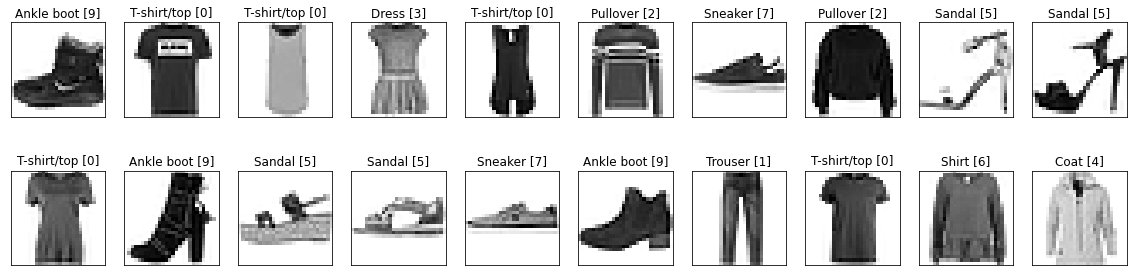

In [9]:
show_example(x_train.cpu(), y_train.cpu().numpy())

We define here a Convolutional Neural Network with a fixed architecture. The network is defined by:

- 2 convolution layers with a $(3\times 3)$ kernel size, zero padding, stride of 1;
- 2 fully connected layers with different in/out features;
- Max-pooling layers with kernel size of $(2\times 2)$ and stride of 2;
- Dropout layer with a class probability of `p`;
- `ReLU` activation function.

From the input image to the output classification, in detail:

**Layer** | **Input size shape** | **Output size shape** 
:-:|:-:|:-:
1 Conv2d | $(28\times 28\times 1)$ | $(26\times 26\times 32)$
1 max_pool | $(26\times 26\times 32)$ | $(13\times 13\times 32)$
2 Conv2d | $(13\times 13\times 32)$ | $(11\times 11\times 64)$
2 max_pool | $(11\times 11\times 64)$ | $(5\times 5\times 64)$

The final fully connected layer has 10 output features for the 10 categories.

A `count_parameter` function is defined to count and print the number of total parameters: the final architecture has been chosen based also on the simplicity of the model.

In [10]:
class Cnn(nn.Module):
    def __init__(self, ks=3, dropout=0.5, act_fn='ReLU'):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=ks)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 5 * 5 * 64 = 1600 = nr channels * width * height
        self.fc2 = nn.Linear(100, 10)
        
        self.act = getattr(nn, act_fn)()
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2_drop(x)
        x = self.conv2(x)
        x = self.act(x)
        x = F.max_pool2d(x, 2)
        
        # Flatten over channel, height and width
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc1_drop(x)
        x = self.fc2(x)
                
        return x
    
    def count_parameters(self):
        table = PrettyTable(['Modules', 'Parameters'])
        total_params = 0
        for name, parameter in self.named_parameters():
            if not parameter.requires_grad: continue
            param = parameter.numel()
            table.add_row([name, param])
            total_params += param
        print(table)
        print(f'Total Trainable Params: {total_params}')
        return total_params
    
    
model = Cnn()
num_trainable_parameters = model.count_parameters()

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    288     |
|  conv1.bias  |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
|  fc1.weight  |   160000   |
|   fc1.bias   |    100     |
|  fc2.weight  |    1000    |
|   fc2.bias   |     10     |
+--------------+------------+
Total Trainable Params: 179926


In [11]:
print(model)

Cnn(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
  (fc1_drop): Dropout(p=0.5, inplace=False)
)


<a id='3'></a>
[Index](#index)
### 3. Training and cross-validation

The model is first trained for a few (10) epochs to test all the learning functions. As a first trial, we use a batch size of $64$, a learning rate of $10^{-3}$ and Adam as optimizer. We then plot the learning curves, compute the accuracy on the test set, show the confusion matrix of the model and plot a series of missclassified samples.

In [12]:
torch.manual_seed(1)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    batch_size=64,
    lr=1e-3,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.CrossEntropyLoss,
    device=device,
)

In [13]:
cnn.fit(x_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8715       0.8042        0.5016  6.6226
      2        0.5988       0.8323        0.4369  5.3737
      3        0.5348       0.8479        0.4016  5.9385
      4        0.5002       0.8610        0.3763  5.2349
      5        0.4722       0.8671        0.3489  5.7342
      6        0.4477       0.8736        0.3361  5.5624
      7        0.4340       0.8778        0.3249  5.5149
      8        0.4186       0.8779        0.3202  6.1165
      9        0.4035       0.8845        0.3090  5.1085
     10        0.3970       0.8878        0.2970  5.1867


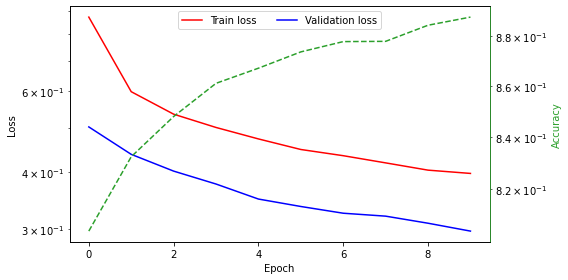

In [14]:
plot_learning_curves(cnn)

In [15]:
x_test = test_dataset.data
y_test = test_dataset.targets

y_pred = cnn.predict(test_dataset)

# Here accuracy_score from sklearn.metrics gives the same result as score of skorch.classifier
print(f'Accuracy on the test set: {accuracy_score(y_test.cpu(), y_pred):.2%}')

Accuracy on the test set: 88.05%


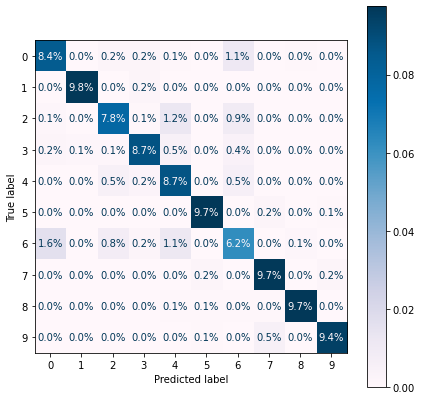

Percentage of missclassified samples: 11.95%


In [16]:
plot_confusion_matrix(y_test.cpu(), y_pred, cnn)

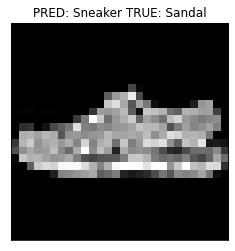

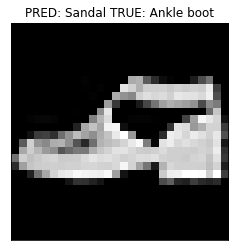

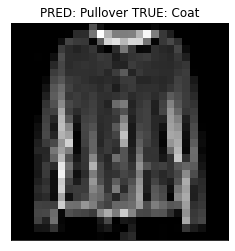

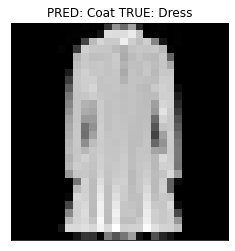

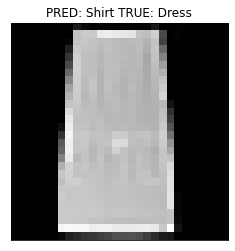

In [17]:
show_missclassified(x_test.cpu(), y_pred, y_test.cpu().numpy())

From this first simple example a good accuracy is reached: the network produces satisfactory results even for a small number of epochs. The diagonal entries of the confusion matrix have a percentages that approach the $10\%$ threshold (all categories are equally present in the dataset), thus confirming the good performances of the network. The differences the model finds most difficult to capture are the ones between the Shirt/T-shirt and Shirt/Pullover categories, which is quite understandable seen how the articles share similar features.

<a id='4'></a>
[Index](#index)
### 4. Randomized search

A random grid search via the `RandomizedSearchCV` method of `sklearn` is used to choose the hyperparameters used during learning. For each of them, a complete description is given below.

* **Batch size**: Random (uniform) choice between $[64, 128, 256]$.
* **Dropout regularization**: Sampled from a log-uniform distribution in the $[0.05:0.6]$ range.
* **Activation function**: A random choice between `ReLU` and `LeakyReLU`.
* **Optimizer**: Random (uniform) choice between `SGD`, `Adam` and `Adadelta`.
* **L2 regularization**: Sampled from a log-uniform distribution in the $[10^{-3}:10^{-1}]$ range.
* **Learning rate**: Sampled from a log-uniform distribution in the $[10^{-4}:10^{-1}]$ range.

The maximum number of epochs is being kept fixed to $10$. It has been noted that the best performance network can be found after a few iterations: when this latter number is increased, the randomized search tends to explore lower-level models. Random search has a probability of $95\%$ of finding a combination of parameters within the $5\%$ optima with only 60 iterations and compared to other methods it doesn't bog down in local optima. Indeed, for any distribution over a sample space with a finite maximum, [the maximum of 60 random observations lies within the top $5\%$ of the true maximum, with $95\%$ probability](https://web.archive.org/web/20160701182750/http://blog.dato.com/how-to-evaluate-machine-learning-models-part-4-hyperparameter-tuning). We thus fix `n_iter` to $100$, to improve that chance with a higher number of trials.

The performance of each instantiated model is again tested on a fixed validation dataset.<br>
`sklearn` does not provide a built-in method for random search without cross-validation. A workaround is given by the `PredefinedSplit` method that provides train/test indices to split data into train/test sets using a predefined scheme specified by the user. The latter is fed into the `cv` argument of `RandomizedSearchCV`, thus providing an artificial indexing that results in a single split to perform validation on. The `refit` argument re-trains an estimator using the best found parameters on the whole dataset: we set it to `False` to keep the (transformed) training set separate from the validation set and carry out a separate training procedure.

In [18]:
x_full = torch.cat((x_train, x_val))
y_full = torch.cat((y_train, y_val))

In [19]:
val_fold = np.concatenate((np.full((len(x_train)),-1), np.zeros(len(x_val))))
ps = PredefinedSplit(val_fold)
val_split = list(ps.split())

In [20]:
n_iter = 100

params = {
    'device'                  : [device],
    'batch_size'              : [64,128,256],
    'module__dropout'         : loguniform.rvs(.05, .6, size=n_iter),
    'module__act_fn'          : ['ReLU', 'LeakyReLU'],
    'optimizer'               : [torch.optim.SGD, torch.optim.Adam, torch.optim.Adadelta],
    'optimizer__weight_decay' : loguniform.rvs(1e-3, 1e-1, size=n_iter),
    'max_epochs'              : [10],
    'lr'                      : loguniform.rvs(1e-4, 1e-1, size=n_iter),
}

scoring = 'accuracy'

gs = RandomizedSearchCV(cnn, param_distributions=params, n_iter=n_iter, refit=False,
                        cv=val_split, scoring=scoring, verbose=2, error_score='raise')

gs.fit(x_full.cpu(), y_full.cpu());

Fitting 1 folds for each of 100 candidates, totalling 100 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3025       0.1148        2.3017  3.2803
      2        2.3012       0.1339        2.3002  3.1415
      3        2.2996       0.1507        2.2987  3.1442
      4        2.2984       0.1668        2.2972  3.2484
      5        2.2971       0.1783        2.2958  3.1046
      6        2.2958       0.1892        2.2944  3.4264
      7        2.2946       0.1955        2.2930  3.4493
      8        2.2932       0.2018        2.2917  3.2699
      9        2.2921       0.2066        2.2904  3.1416
     10        2.2908       0.2124        2.2891  3.1037
[CV] END batch_size=256, device=cuda, lr=0.00017688710166816112, max_epochs=10, module__act_fn=ReLU, module__dropout=0.1099729270859198, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__weight_decay=0.003971681675782142; total time=  33.1s
  epoch   

[CV] END batch_size=128, device=cuda, lr=0.08733246004963871, max_epochs=10, module__act_fn=ReLU, module__dropout=0.08575687553038024, optimizer=<class 'torch.optim.adadelta.Adadelta'>, optimizer__weight_decay=0.0010126892454659087; total time=  47.8s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2225       0.5109        2.0035  4.7271
      2        1.4650       0.6272        1.0270  4.8328
      3        1.0528       0.6921        0.8762  4.8687
      4        0.9367       0.7093        0.8012  5.0024
      5        0.8717       0.7233        0.7571  4.9091
      6        0.8365       0.7252        0.7314  5.3155
      7        0.8052       0.7429        0.7049  5.6720
      8        0.7840       0.7472        0.6863  5.6173
      9        0.7652       0.7454        0.6708  5.5253
     10        0.7453       0.7547        0.6534  5.7049
[CV] END batch_size=64, device=cuda, lr=0.0039076274608879445, m

      9        2.2744       0.3091        2.2695  3.3301
     10        2.2705       0.3141        2.2659  3.1285
[CV] END batch_size=256, device=cuda, lr=0.0007791931433573509, max_epochs=10, module__act_fn=ReLU, module__dropout=0.2814025612959478, optimizer=<class 'torch.optim.adadelta.Adadelta'>, optimizer__weight_decay=0.08806487562436757; total time=  35.6s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7973       0.6813        0.7662  3.4606
      2        0.7460       0.7527        0.6426  3.2513
      3        0.7153       0.7820        0.6006  3.1788
      4        0.6943       0.7822        0.6005  3.2321
      5        0.6779       0.7565        0.6144  3.1771
      6        0.6745       0.7877        0.5784  3.1253
      7        0.6757       0.7766        0.5834  3.1976
      8        0.6618       0.7980        0.5474  3.2282
      9        0.6537       0.8067        0.5355  3.2173
     10 

      8        0.6557       0.7910        0.5692  3.2827
      9        0.6475       0.7902        0.5667  3.5079
     10        0.6388       0.7972        0.5579  3.7623
[CV] END batch_size=128, device=cuda, lr=0.07429642682935281, max_epochs=10, module__act_fn=ReLU, module__dropout=0.360099049732151, optimizer=<class 'torch.optim.adadelta.Adadelta'>, optimizer__weight_decay=0.026990254458741147; total time=  37.4s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3088       0.0999        2.3077  2.8086
      2        2.3072       0.0999        2.3063  2.7948
      3        2.3058       0.0999        2.3049  2.7324
      4        2.3046       0.0999        2.3035  2.8142
      5        2.3035       0.0999        2.3023  2.7352
      6        2.3024       0.0999        2.3010  2.7976
      7        2.3010       0.0999        2.2998  2.7265
      8        2.2999       0.0999        2.2986  2.7434
      9   

      9        0.5336       0.8110        0.4942  3.2895
     10        0.5165       0.8192        0.4821  3.1890
[CV] END batch_size=256, device=cuda, lr=0.033929746790917134, max_epochs=10, module__act_fn=ReLU, module__dropout=0.07917906111257293, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__weight_decay=0.001676521900250892; total time=  33.6s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7334       0.6352        1.0253  5.8403
      2        0.9596       0.7078        0.8384  5.8940
      3        0.8416       0.7384        0.7566  5.9475
      4        0.7778       0.7477        0.7079  6.2058
      5        0.7319       0.7599        0.6688  6.4477
      6        0.6979       0.7677        0.6410  6.0515
      7        0.6672       0.7780        0.6133  7.0115
      8        0.6432       0.7837        0.5928  7.0501
      9        0.6213       0.7898        0.5735  6.7753
     10        0.

      9        1.3323       0.5924        1.0513  4.0813
     10        1.3445       0.6069        1.0079  3.8193
[CV] END batch_size=64, device=cuda, lr=0.033929746790917134, max_epochs=10, module__act_fn=LeakyReLU, module__dropout=0.4705942549869745, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=0.03783697838333603; total time=  41.3s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3025       0.1000        2.3004  2.9182
      2        2.2979       0.1000        2.2954  2.8061
      3        2.2939       0.1000        2.2904  2.8137
      4        2.2888       0.1000        2.2849  2.8470
      5        2.2833       0.1011        2.2786  2.7888
      6        2.2769       0.1585        2.2715  2.7926
      7        2.2694       0.1906        2.2634  3.4245
      8        2.2612       0.2106        2.2540  2.8473
      9        2.2524       0.2266        2.2430  3.3386
     10      

      9        0.5236       0.8235        0.4979  2.8112
     10        0.5245       0.8063        0.5302  2.8275
[CV] END batch_size=256, device=cuda, lr=0.00919182043344855, max_epochs=10, module__act_fn=ReLU, module__dropout=0.1057114250356076, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=0.013363849240437512; total time=  29.2s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2883       0.2031        2.2568  3.0256
      2        2.2085       0.4566        2.1071  2.9317
      3        1.9218       0.5727        1.5656  2.9169
      4        1.4483       0.6172        1.1306  2.9541
      5        1.2080       0.6455        0.9901  2.9338
      6        1.0941       0.6710        0.9182  2.9654
      7        1.0201       0.6877        0.8671  2.9515
      8        0.9703       0.6999        0.8314  2.9332
      9        0.9342       0.7092        0.8031  3.2777
     10        0.

      9        0.5374       0.8341        0.4319  2.8540
     10        0.5305       0.8374        0.4278  2.8364
[CV] END batch_size=256, device=cuda, lr=0.003464541322016153, max_epochs=10, module__act_fn=ReLU, module__dropout=0.44876877783850866, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=0.006675122800262951; total time=  29.6s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3023       0.0997        2.3008  3.3817
      2        2.2996       0.0995        2.2983  3.3310
      3        2.2973       0.1042        2.2960  3.3031
      4        2.2953       0.1308        2.2937  3.2969
      5        2.2934       0.1689        2.2916  3.3225
      6        2.2911       0.2103        2.2894  3.3369
      7        2.2891       0.2423        2.2873  3.2738
      8        2.2871       0.2693        2.2853  3.5013
      9        2.2852       0.2897        2.2833  3.3004
     10        

      7        2.2953       0.1542        2.2937  2.9633
      8        2.2942       0.1595        2.2926  2.9356
      9        2.2932       0.1635        2.2914  2.9045
     10        2.2918       0.1670        2.2903  2.9314
[CV] END batch_size=256, device=cuda, lr=0.00015270602674096126, max_epochs=10, module__act_fn=LeakyReLU, module__dropout=0.0945121165988273, optimizer=<class 'torch.optim.adadelta.Adadelta'>, optimizer__weight_decay=0.001146817529351579; total time=  30.5s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2829       0.3045        2.2590  3.2040
      2        2.2113       0.4668        2.1290  2.9504
      3        1.8941       0.5706        1.5192  2.9529
      4        1.2476       0.6524        1.0280  3.0029
      5        0.9900       0.6875        0.8821  2.9788
      6        0.8901       0.7125        0.8084  2.9493
      7        0.8324       0.7240        0.7626  2.9357
 

      7        2.2225       0.3845        2.2046  3.2221
      8        2.2014       0.3759        2.1790  3.2034
      9        2.1746       0.3748        2.1485  3.2346
     10        2.1444       0.3853        2.1124  3.2194
[CV] END batch_size=128, device=cuda, lr=0.0009194993645411002, max_epochs=10, module__act_fn=ReLU, module__dropout=0.4768785911353187, optimizer=<class 'torch.optim.adadelta.Adadelta'>, optimizer__weight_decay=0.018580394880104996; total time=  32.9s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6465       0.6492        0.9482  3.5690
      2        0.9063       0.7122        0.7936  3.4178
      3        0.8117       0.7306        0.7350  3.4010
      4        0.7627       0.7448        0.6933  3.4369
      5        0.7271       0.7549        0.6712  4.4052
      6        0.6967       0.7649        0.6393  5.0933
      7        0.6738       0.7712        0.6210  3.7676
      8

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2538       0.7250        0.7784  3.2235
      2        0.9929       0.7218        0.8039  3.1812
      3        0.9938       0.7283        0.8001  2.9715
      4        0.9875       0.7150        0.8254  3.1433
      5        0.9736       0.7289        0.7792  3.4667
      6        0.9767       0.7202        0.8075  3.1971
      7        0.9734       0.7350        0.7733  2.9635
      8        0.9871       0.7250        0.7955  3.7822
      9        0.9853       0.7270        0.8029  3.1402
     10        0.9793       0.6989        0.8434  2.8406
[CV] END batch_size=256, device=cuda, lr=0.0204519577423497, max_epochs=10, module__act_fn=ReLU, module__dropout=0.5538313763073295, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=0.04928475172629006; total time=  32.7s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ----------

      4        0.7867       0.7349        0.7150  4.2423
      5        0.7437       0.7452        0.6813  3.9958
      6        0.7081       0.7559        0.6491  4.0624
      7        0.6769       0.7639        0.6228  3.9538
      8        0.6501       0.7738        0.5977  4.3408
      9        0.6272       0.7791        0.5778  4.1739
     10        0.6047       0.7880        0.5593  4.6984
[CV] END batch_size=64, device=cuda, lr=0.004975764824988637, max_epochs=10, module__act_fn=ReLU, module__dropout=0.0664905398926066, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__weight_decay=0.0035273850224319253; total time=  43.9s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3298       0.6518        0.9916  3.5837
      2        1.1150       0.6605        0.9501  3.7220
      3        1.0834       0.6640        0.9475  3.2780
      4        1.0635       0.6661        0.9390  3.2635
      5        1.0

      5        2.2885       0.2519        2.2860  3.6393
      6        2.2858       0.2582        2.2834  3.1018
      7        2.2834       0.2625        2.2808  3.1608
      8        2.2808       0.2632        2.2782  3.4403
      9        2.2782       0.2635        2.2756  3.2557
     10        2.2760       0.2625        2.2729  3.7797
[CV] END batch_size=256, device=cuda, lr=0.0002785655291123537, max_epochs=10, module__act_fn=ReLU, module__dropout=0.12991779595170097, optimizer=<class 'torch.optim.adadelta.Adadelta'>, optimizer__weight_decay=0.029669091035777334; total time=  33.1s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5885       0.6188        0.9968  3.3437
      2        1.0036       0.7078        0.8460  3.2932
      3        0.9054       0.7259        0.7838  3.1791
      4        0.8577       0.7349        0.7507  3.2469
      5        0.8239       0.7447        0.7265  3.0689
      

      5        1.9498       0.5201        1.7810  3.2153
      6        1.7228       0.5513        1.5001  3.0092
      7        1.5204       0.5941        1.2984  3.0722
      8        1.3862       0.6094        1.1778  3.4126
      9        1.2967       0.6245        1.1023  3.7730
     10        1.2318       0.6397        1.0495  3.4667
[CV] END batch_size=128, device=cuda, lr=0.0013448416121093485, max_epochs=10, module__act_fn=LeakyReLU, module__dropout=0.5172488563320604, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__weight_decay=0.024841698832512818; total time=  32.7s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2948       0.0936        2.2878  5.6336
      2        2.2836       0.2164        2.2771  4.6501
      3        2.2732       0.3706        2.2659  4.6254
      4        2.2617       0.4171        2.2538  4.1159
      5        2.2488       0.4350        2.2397  4.0865
      6     

      5        2.3003       0.1952        2.2985  3.2648
      6        2.2986       0.2064        2.2968  3.0725
      7        2.2970       0.2167        2.2951  3.0595
      8        2.2953       0.2279        2.2933  3.0122
      9        2.2936       0.2403        2.2915  3.0065
     10        2.2919       0.2494        2.2895  3.1673
[CV] END batch_size=256, device=cuda, lr=0.00045518003826813943, max_epochs=10, module__act_fn=ReLU, module__dropout=0.1057114250356076, optimizer=<class 'torch.optim.sgd.SGD'>, optimizer__weight_decay=0.010895497514649268; total time=  32.1s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2139       0.6469        0.8937  4.0465
      2        1.0907       0.5939        1.0274  4.0150
      3        1.0921       0.6503        0.9373  3.8322
      4        1.1130       0.6655        0.8983  3.2265
      5        1.1871       0.5755        1.1315  4.4025
      6        1

Results are collected in a `DataFrame`: the best parameters are retrieved considering the maximum of the `mean_test_score` argument, which coincides with `split0_test_score` as we consider a single fold. We retrain the network with this new set of parameters for a greater number of epochs on the augmented training set and consider again accuracy on the test set and the corresponding confusion matrix.

In [21]:
results = pd.DataFrame(gs.cv_results_)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__weight_decay,param_optimizer,param_module__dropout,param_module__act_fn,param_max_epochs,param_lr,param_device,param_batch_size,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,32.439924,0.0,0.647621,0.0,0.003972,<class 'torch.optim.sgd.SGD'>,0.109973,ReLU,10,0.000177,cuda,256,{'optimizer__weight_decay': 0.0039716816757821...,0.210583,0.210583,0.0,94
1,42.055475,0.0,0.458961,0.0,0.04264,<class 'torch.optim.adadelta.Adadelta'>,0.066491,ReLU,10,0.026772,cuda,128,{'optimizer__weight_decay': 0.0426402907432457...,0.759333,0.759333,0.0,41
2,47.992169,0.0,0.608099,0.0,0.001467,<class 'torch.optim.sgd.SGD'>,0.22284,LeakyReLU,10,0.012687,cuda,64,{'optimizer__weight_decay': 0.0014670640113977...,0.824333,0.824333,0.0,17
3,39.987741,0.0,0.472845,0.0,0.009679,<class 'torch.optim.sgd.SGD'>,0.121717,LeakyReLU,10,0.00057,cuda,128,{'optimizer__weight_decay': 0.0096792271682295...,0.301250,0.301250,0.0,86
4,34.957042,0.0,0.680037,0.0,0.001845,<class 'torch.optim.adadelta.Adadelta'>,0.090664,LeakyReLU,10,0.052078,cuda,256,{'optimizer__weight_decay': 0.0018450367296174...,0.817167,0.817167,0.0,19
5,45.570918,0.0,0.494485,0.0,0.003972,<class 'torch.optim.adadelta.Adadelta'>,0.051523,LeakyReLU,10,0.000214,cuda,128,{'optimizer__weight_decay': 0.0039716816757821...,0.155167,0.155167,0.0,99
6,47.361491,0.0,0.481236,0.0,0.001013,<class 'torch.optim.adadelta.Adadelta'>,0.085757,ReLU,10,0.087332,cuda,128,{'optimizer__weight_decay': 0.0010126892454659...,0.863250,0.863250,0.0,3
7,52.391112,0.0,0.654130,0.0,0.010895,<class 'torch.optim.sgd.SGD'>,0.360099,LeakyReLU,10,0.003908,cuda,64,{'optimizer__weight_decay': 0.0108954975146492...,0.752583,0.752583,0.0,42
8,52.235878,0.0,0.570892,0.0,0.005111,<class 'torch.optim.sgd.SGD'>,0.281403,ReLU,10,0.000998,cuda,64,{'optimizer__weight_decay': 0.0051107944117826...,0.681000,0.681000,0.0,65
9,37.411921,0.0,0.443665,0.0,0.001611,<class 'torch.optim.sgd.SGD'>,0.201869,LeakyReLU,10,0.000455,cuda,128,{'optimizer__weight_decay': 0.0016111770698442...,0.195250,0.195250,0.0,96


In [22]:
best = results.nlargest(1, 'mean_test_score')
index = best.index.values.astype(int)[0]
best = best.to_dict()
best_score = best['mean_test_score'][index]
print(f'Best score achieved: {best_score:.2%}\n')

best_params_set = best['params'][index]
print('Best parameters found:\n')
print(json.dumps(best_params_set, indent=2, sort_keys=True, default=str))

Best score achieved: 86.83%

Best parameters found:

{
  "batch_size": 256,
  "device": "cuda",
  "lr": 0.000516410281920505,
  "max_epochs": 10,
  "module__act_fn": "LeakyReLU",
  "module__dropout": 0.1057114250356076,
  "optimizer": "<class 'torch.optim.adam.Adam'>",
  "optimizer__weight_decay": 0.004060271375708865
}


In [23]:
best_cnn = NeuralNetClassifier(
    Cnn,
    module__act_fn=best_params_set['module__act_fn'],
    module__dropout=best_params_set['module__dropout'],
    max_epochs=30,
    batch_size=best_params_set['batch_size'],
    lr=best_params_set['lr'],
    optimizer=best_params_set['optimizer'],
    optimizer__weight_decay=best_params_set['optimizer__weight_decay'],
    criterion=torch.nn.CrossEntropyLoss,
    device=device,
)

In [24]:
best_cnn.fit(x_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0910       0.7662        0.6242  3.6025
      2        0.6082       0.8072        0.5212  3.4642
      3        0.5305       0.8258        0.4735  3.3149
      4        0.4910       0.8429        0.4440  3.0445
      5        0.4625       0.8457        0.4253  3.1470
      6        0.4406       0.8551        0.4036  2.7530
      7        0.4236       0.8602        0.3928  2.7841
      8        0.4111       0.8645        0.3831  3.0306
      9        0.4010       0.8677        0.3757  2.9026
     10        0.3887       0.8693        0.3675  2.8780
     11        0.3819       0.8728        0.3595  2.9243
     12        0.3737       0.8762        0.3532  2.8004
     13        0.3694       0.8781        0.3472  2.7526
     14        0.3634       0.8786        0.3429  2.8271
     15        0.3573       0.8800        0.3395  2.7548
     16        0.3552       0.8

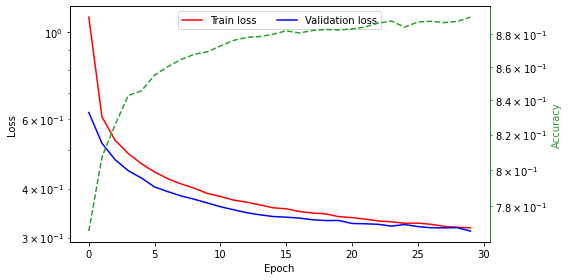

In [25]:
plot_learning_curves(best_cnn)

In [26]:
y_pred = best_cnn.predict(test_dataset)

print(f'Accuracy on the test set: {accuracy_score(y_test.cpu(), y_pred):.2%}')

Accuracy on the test set: 88.18%


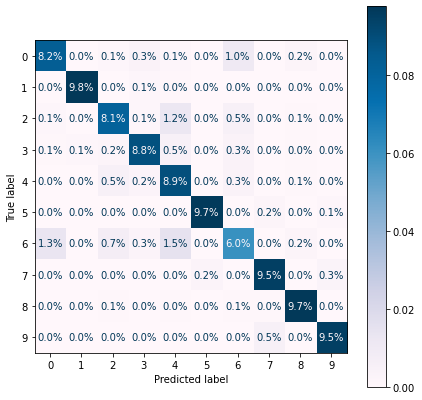

Percentage of missclassified samples: 11.82%


In [27]:
plot_confusion_matrix(y_test.cpu(), y_pred, best_cnn)

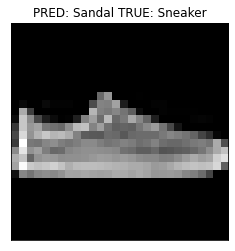

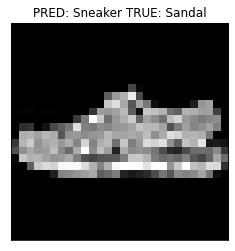

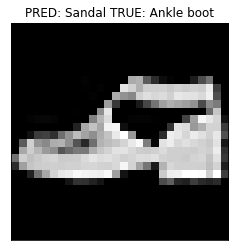

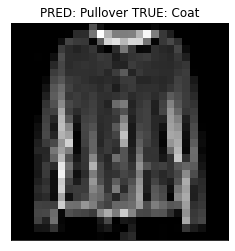

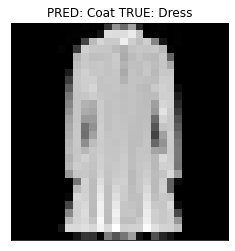

In [28]:
show_missclassified(x_test.cpu(), y_pred, y_test.cpu().numpy())

After the final re-train of the network the model reaches $\approx 88.18\%$ accuracy on the test set.

However, the performance does not improve enough to justify the resources employed in the search for a better model. The hyperparameters chosen are only minorly tweaked with respect to the baseline model and do not influence dramatically the inner workings of the network. This suggests that in order to obtain a significant change one way would be to act directly on the network architecture. A first idea would be to remove the max-pooling layers to add further complexity - at the cost of rising significantly the number of trainable parameters.

<a id='5'></a>
[Index](#index)
### 5. Under the hood

We visualize the inner workings of the network by plotting the weight histograms and kernels (filters).

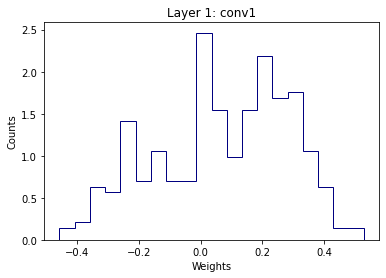

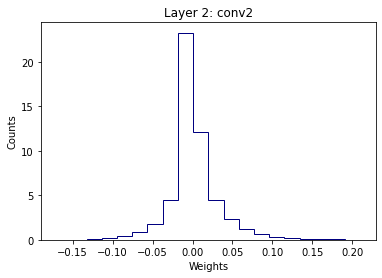

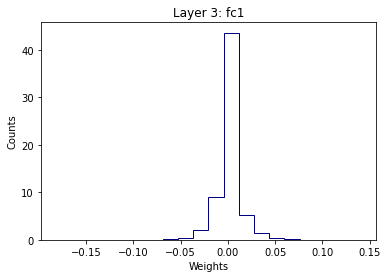

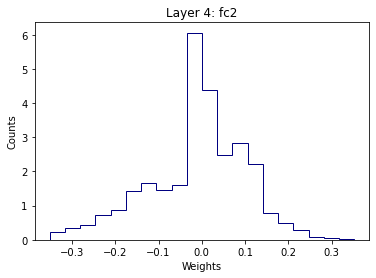

In [29]:
layers = [best_cnn.module_.conv1, best_cnn.module_.conv2, best_cnn.module_.fc1, best_cnn.module_.fc2]
name_layer = ['conv1', 'conv2', 'fc1', 'fc2']

for num, layer in enumerate(layers):
    weights = layer.weight.detach().cpu().numpy()
    plt.hist(weights.flatten(), bins=20, density=True, color='navy', histtype='step')
    plt.xlabel('Weights'); plt.ylabel('Counts')
    plt.title(f'Layer {num+1}: {name_layer[num]}')
    plt.show()

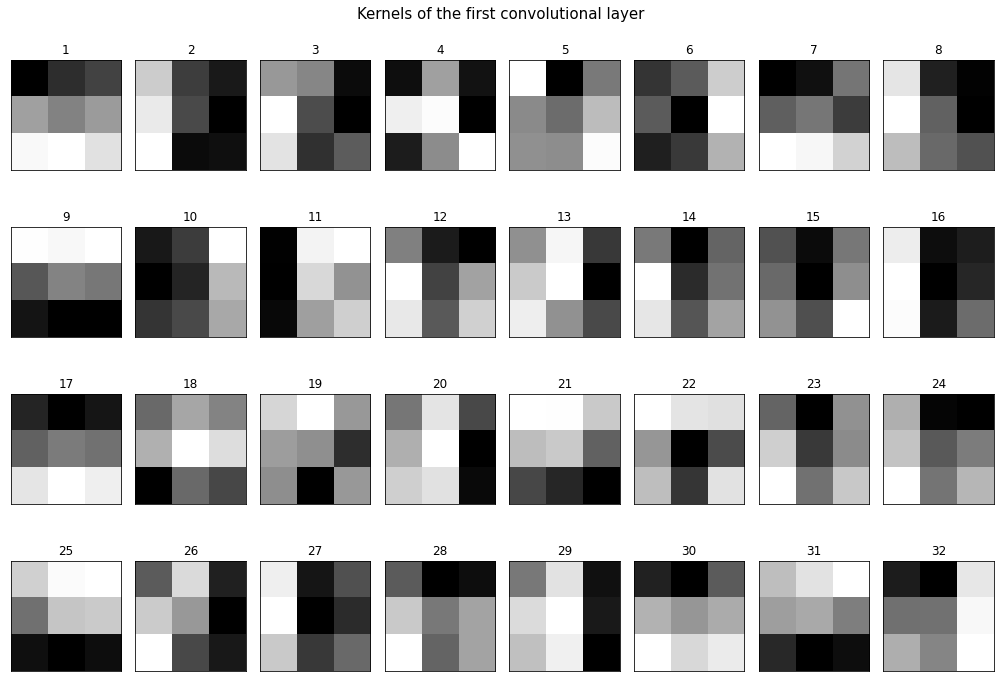

In [30]:
weights = layers[0].weight.detach().cpu().numpy()

n = int(weights.shape[0])
n_rows = 8; n_col = 4
assert n_rows * n_col == n, '#rows * #col must match #filters!'

fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(weights.shape[0]):
    ax = fig.add_subplot(int(n/n_rows), int(n/n_col), i+1)
    ax.imshow(weights[i, 0], aspect='auto', cmap='binary')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'{i+1}')
    
plt.suptitle('Kernels of the first convolutional layer', size=15)
plt.tight_layout()

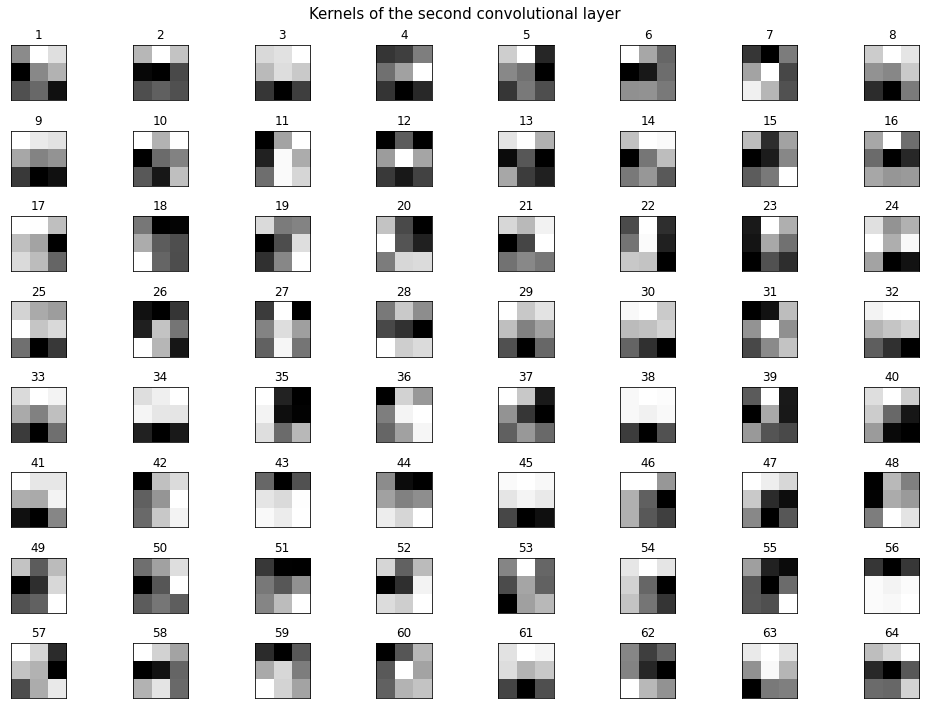

In [31]:
weights = layers[1].weight.detach().cpu().numpy()

n = int(weights.shape[0])
n_rows = 8; n_col = 8
assert n_rows * n_col == n, '#rows * #col must match #filters!'

fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(weights.shape[0]):
    ax = fig.add_subplot(int(n/n_rows), int(n/n_col), i+1)
    ax.imshow(weights[i, 0], aspect='auto', cmap='binary')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'{i+1}')
    
plt.suptitle('Kernels of the second convolutional layer', size=15)
plt.tight_layout()

The kernels appear to be mostly edge detectors like horizontal lines (first block, #9), vertical (first block, #11) and diagonal (second block, #10).

Lastly, their effect can be made more evident when applied to a sample image: the feature maps obtained are shown below. In this way the actions guessed can be directly observed.

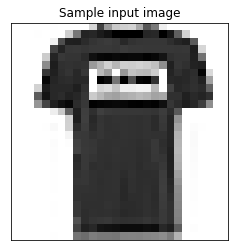

In [32]:
ex = train_dataset[1][0].cpu() 
plt.imshow(ex.squeeze(0).cpu().detach().numpy(), cmap='binary')
plt.xticks([]); plt.yticks([])
plt.title('Sample input image')
plt.show()

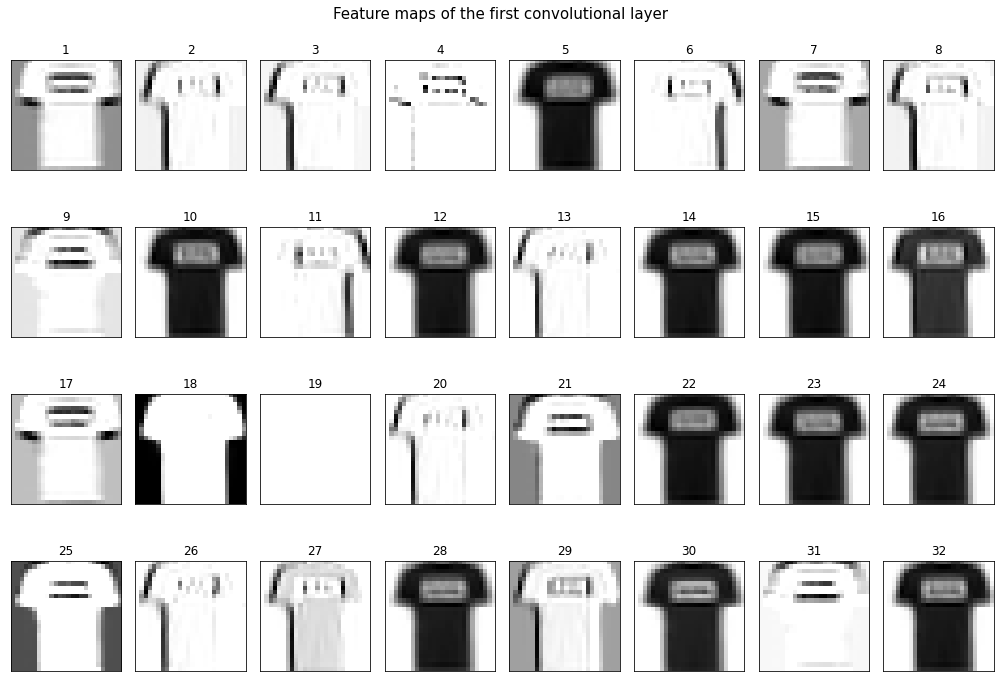

In [33]:
# Register output after the first convolutional layer

layers = [best_cnn.module_.conv1, nn.ReLU()]
x = ex.unsqueeze(0).to(device)

for layer in layers: 
    x = layer(x)
    
out_conv1 = x.squeeze(0).cpu().detach().numpy()
n = len(out_conv1)
n_rows = 8; n_col = 4
assert n_rows * n_col == n, '#rows * #col must match #filters!'

fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, fmap in enumerate(out_conv1):
    ax = fig.add_subplot(int(n/n_rows), int(n/n_col), i+1)
    ax.imshow(fmap, aspect='auto', cmap='binary')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'{i+1}')

plt.suptitle('Feature maps of the first convolutional layer', size=15)
plt.tight_layout()

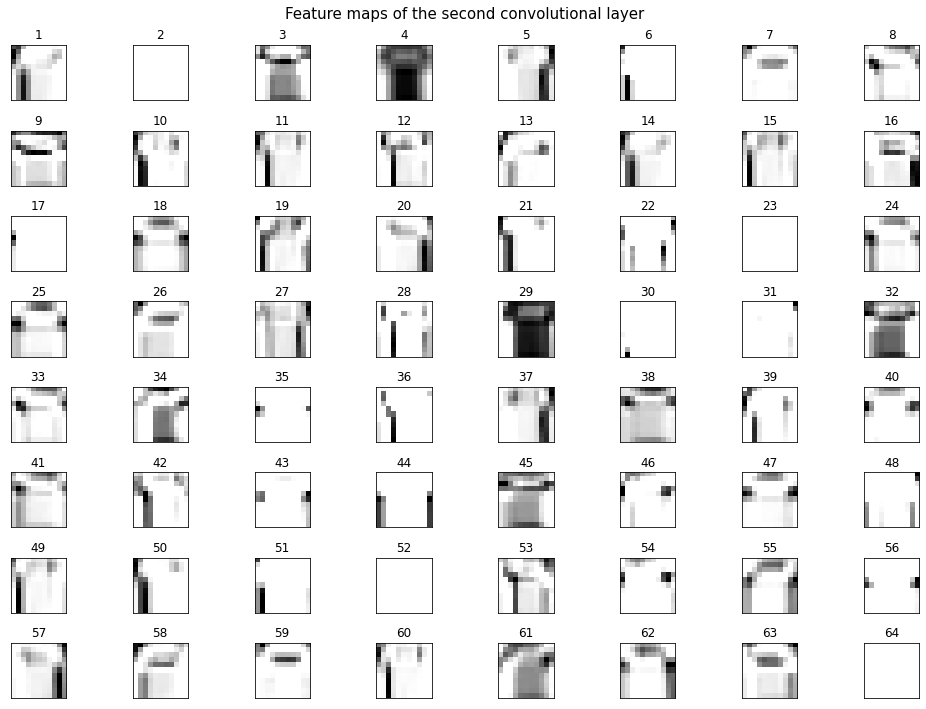

In [34]:
# Register output after the second convolutional layer

layers = [best_cnn.module_.conv1, nn.ReLU(), F.max_pool2d, best_cnn.module_.conv2, nn.ReLU()]
x = ex.unsqueeze(0).to(device)

for layer in layers:
    if layer == F.max_pool2d:
        x = layer(x, 2)
    else:
        x = layer(x)
    
out_conv2 = x.squeeze(0).cpu().detach().numpy()
n = len(out_conv2)
n_rows = 8; n_col = 8
assert n_rows * n_col == n, '#rows * #col must match #filters!'

fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, fmap in enumerate(out_conv2):
    ax = fig.add_subplot(int(n/n_rows), int(n/n_col), i+1)
    ax.imshow(fmap, aspect='auto', cmap='binary')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f'{i+1}')

plt.suptitle('Feature maps of the second convolutional layer', size=15)
plt.tight_layout()

<a id='6'></a>
[Index](#index)
### 6. Conclusion

In this work we showed an example of classification using a simple convolutional neural network via `PyTorch` and `Skorch`. The task has been carried out using a fixed test/validation dataset split, together with an extensive randomized search of the hyperparameters: the latter has produced similar results to the reference base model. This suggests that a possible future research should concentrate first on the network architecture rather than the optimization of its hyperparameters. Kernels and feature maps of the network where also visualized. The obtained results are deemed satisfactory, with a reached final accuracy on the test set of $\approx 88.18\%$.